In [180]:
from classy import Class
import numpy as np
import scipy


import matplotlib.pylab as plt

from colossus.cosmology import cosmology
from colossus.lss import mass_function
import scipy.integrate as integrate


In [181]:
#Start by specifying the cosmology
Omega_b = 0.05
Omega_m = 0.3
Omega_cdm = Omega_m - Omega_b
h = 0.7 #H0/100
A_s = 2.1e-9
n_s = 0.96


#Create a params dictionary

k_max = 0.001 #UNITS: 1/Mpc

params = {
             'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':0.05
}

#Initialize the cosmology andcompute everything
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k = np.logspace(0, np.log10(k_max), num=1000) #Mpc^-1
z = 0.1

#Calculate the linear matter power spectra
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])

#convert these to h/Mpc and (Mpc/h)^3
k /= h
Plin *= h**3

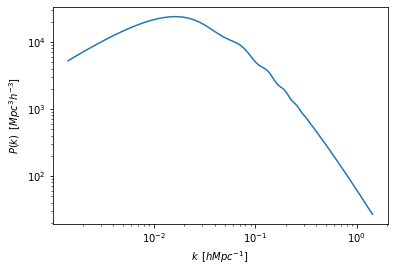

In [182]:
plt.figure()
plt.xlabel(r'$k\,\ [h Mpc^{-1}]$')
plt.ylabel(r'$P(k)\,\ [Mpc^3 h^{-3}]$')
plt.plot(k,Plin)
plt.xscale("log")
plt.yscale("log")

In [183]:
#set constants 
M=10**14
z=0.1

In [184]:
#estimate dndm
cosmology.setCosmology('WMAP9')
dndm = mass_function.massFunction(M, z, mdef = 'vir', model = 'tinker08')

In [185]:
print(dndm)

0.19153762333178637


In [186]:
#estimate b_1, the linear halo bias of Tinker 2010
from colossus.lss import bias
b_1 = bias.haloBias(M, z,mdef='vir',model='tinker10')

In [187]:
print(b_1)

2.3569485855303456


In [188]:
#estimate  radial distribution of satellite galaxies in a halo (NFW profile)
def u_sat(r_s,r_max,k,M):
    
    def int(r):
        return 4*np.pi*r**2*1/((r/r_s)*(r/r_s+1)**2)*np.heaviside(r_max-r,0)*np.sin(k*r)/(k*r)
    
    u=1/M*integrate.quad(int,0,r_s)[0]
    return u

In [189]:
print(u_sat(1,1,1,1))

2.265828372622493


In [190]:
#estimate the HOD values
from scipy import special

def hod(M,M_min,M_1,alpha):
    #define some constants according to the paper
    sd_log_M=0.15
    M_0=M_min
    
    N_cen=1/2*(1+special.erf((np.log(M)-np.log(M_min))/sd_log_M)) #number of central galaxies
    
    N_sat=((M-M_0)/M_1)**alpha*np.heaviside(M-M_0,0) #number of satellite galaxies
    
    return N_cen,N_sat

print(hod(5,3,3,1)[1])

0.6666666666666666


In [191]:
#compute the mean number of density of galaxies

def n_g(z,M_i,M_f,M_min,M_1,alpha):
    def int(M):
        cosmology.setCosmology('WMAP9')
        return mass_function.massFunction(M, z, mdef = 'vir', model = 'tinker08')*(hod(M,M_min,M_1,alpha)[0]+hod(M,M_min,M_1,alpha)[1])
    return integrate.quad(int,M_i,M_f)[0]

In [192]:
#compute the scale-dependent galaxy bias

def b_g(z,k,M_i,M_f,M_min,M_1,alpha,r_s,r_max):
    def b_g_integration(M):
        return mass_function.massFunction(M, z, mdef = 'vir', model = 'tinker08')*(hod(M,M_min,M_1,alpha)[0]+hod(M,M_min,M_1,alpha)[1]*u_sat(r_s,r_max,k,M))*bias.haloBias(M, z,mdef='vir',model='tinker10')
    
    #calculation of scale-dependent galaxy bias
    b_g=(1/n_g(z,M_i,M_f,M_min,M_1,alpha))*(integrate.quad(b_g_integration,M_i,M_f)[0])
        
    return b_g

In [193]:
#define the 2 halo term function
        

def P_g_2h(z,k_arr,M_i,M_f,M_min,M_1,alpha,r_s,r_max): #input k as an array
    P_2h=np.array([])
    for ki in k:
        P_2h=np.append(P_2h,b_g(z,ki*h,M_i,M_f,M_min,M_1,alpha,r_s,r_max)**2*(cosmo.pk_lin(ki, z)*h**3))
    
    return P_2h

In [194]:
z=0.1
k_arr = np.logspace(0, np.log10(0.001), num=1000)
M_i=10**14
M_f=10**15
M_min=10**11.84
M_1=10*11.98
alpha=0.84
r_s=0.62
r_max=6.9

P_g_2=P_g_2h(z,k_arr,M_i,M_f,M_min,M_1,alpha,r_s,r_max)

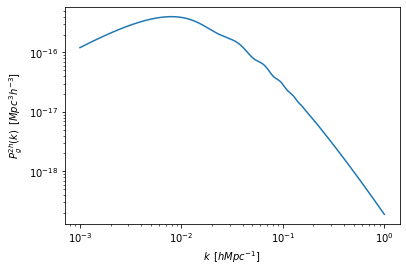

In [195]:
plt.figure()
plt.xlabel(r'$k\,\ [h Mpc^{-1}]$')
plt.ylabel(r'$P_g^{2h}(k)\,\ [Mpc^3 h^{-3}]$')
plt.plot(k_arr,P_g_2)
plt.xscale("log")
plt.yscale("log")

In [196]:
def P_g_1h(z,k_arr,M_i,M_f,M_min,M_1,alpha,r_s,r_max): #input k as an array
    def int(M):
        dndm=mass_function.massFunction(M, z, mdef = 'vir', model = 'tinker08')
        n_sat=hod(M,M_min,M_1,alpha)[1]
        u=u_sat(r_s,r_max,k,M)
        return dndm*(2*n_sat*u+n_sat**2*(np.abs(u))**2)**2
    P_g_1=np.array([])
    for ki in k_arr:
        k=ki*h
        P_g_1=np.append(P_g_1,1/n_g(z,M_i,M_f,M_min,M_1,alpha)**2*integrate.quad(int,M_i,M_f)[0])
    return P_g_1

In [197]:
z=0.1
k_arr = np.logspace(0, np.log10(0.001), num=1000)
M_i=10**14
M_f=10**15
M_min=10**11.84
M_1=10*11.98
alpha=0.84
r_s=0.62
r_max=6.9

P_g_1=P_g_1h(z,k_arr,M_i,M_f,M_min,M_1,alpha,r_s,r_max)

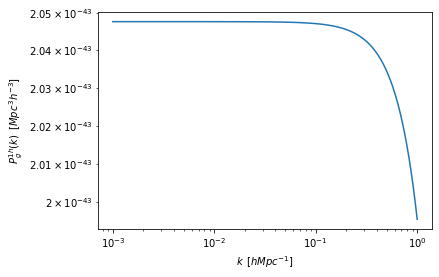

In [198]:
plt.figure()
plt.xlabel(r'$k\,\ [h Mpc^{-1}]$')
plt.ylabel(r'$P_g^{1h}(k)\,\ [Mpc^3 h^{-3}]$')
plt.plot(k_arr,P_g_1)
plt.xscale("log")
plt.yscale("log")

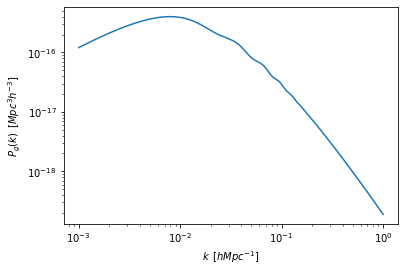

In [199]:
plt.figure()
plt.xlabel(r'$k\,\ [h Mpc^{-1}]$')
plt.ylabel(r'$P_g(k)\,\ [Mpc^3 h^{-3}]$')
plt.plot(k_arr,P_g_1+P_g_2)
plt.xscale("log")
plt.yscale("log")

In [ ]:
#projection of power spectrum onto two dimensional sky

def proj(p,x_i,x_f):#where p is the power spectrum, array
    def int(x):
        return 1/x^2*w_g**2*p(l/x,z)
    c_l=integrate.quad(int,x_i,x_f)